In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [4]:
df = pd.read_csv("../data/processed/processed_reviews.csv")

In [6]:
df.head()

,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,1,408,2,0.018448,-1.0,0.512241,1.0,"['travel', 'travel', 'often', 'last', 'week', ...","['bad', 'airline']",Wednesday,11,2024
1,1,157,4,-0.060897,-1.0,0.592949,1.0,"['review', 'regard', 'economy', 'flex', 'choos...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,1,259,11,-0.094163,-0.6,0.488287,0.7,"['recently', 'fly', 'hong', 'kong', 'nov', 'th...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,1,274,1,-0.109373,-1.0,0.494012,1.0,"['wow', 'experience', 'I', 've', 'fly', 'porte...",['horrible'],Monday,11,2024
4,1,311,7,-0.126476,-1.0,0.485192,1.0,"['spend', 'day', 'vacation', 'hong', 'kong', '...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024


In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()


def get_vader_sentiment(text):
    if isinstance(text, str):
        scores = vader_analyzer.polarity_scores(text)
        return scores["compound"]


df["vader_sentiment"] = df["lemmatized_text"].apply(get_vader_sentiment)


In [ ]:
df["vader_label"] = df["vader_sentiment"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

In [9]:
df[["lemmatized_text", "vader_sentiment", "vader_label"]].head()

,lemmatized_text,vader_sentiment,vader_label
0,"['travel', 'travel', 'often', 'last', 'week', ...",-0.5574,negative
1,"['review', 'regard', 'economy', 'flex', 'choos...",-0.8957,negative
2,"['recently', 'fly', 'hong', 'kong', 'nov', 'th...",-0.9683,negative
3,"['wow', 'experience', 'I', 've', 'fly', 'porte...",-0.9686,negative
4,"['spend', 'day', 'vacation', 'hong', 'kong', '...",-0.8516,negative


In [ ]:
# Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df["lemmatized_text"].astype(str))
y = df["rating"].apply(
    lambda x: 1 if x > 3 else 0
)  # Binary sentiment: 1 (positive), 0 (negative)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.78      0.82      0.80       260
           1       0.81      0.75      0.78       252

    accuracy                           0.79       512
   macro avg       0.79      0.79      0.79       512
weighted avg       0.79      0.79      0.79       512

Accuracy: 0.7891


In [ ]:
# Load pre-trained BERT sentiment classifier
bert_sentiment = pipeline("sentiment-analysis")


def get_bert_sentiment(text):
    if isinstance(text, str):
        # Truncate text if it's too long for BERT
        text = text[:500]  # Keeping it within a safe limit
        result = bert_sentiment(text)[0]  # Get sentiment prediction
        return result["label"], result["score"]
    return "neutral", 0  # Default for missing values


# Apply BERT sentiment analysis
df["bert_label"], df["bert_score"] = zip(
    *df["lemmatized_text"].apply(get_bert_sentiment)
)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


                                     lemmatized_text bert_label  bert_score
0  ['travel', 'travel', 'often', 'last', 'week', ...   NEGATIVE    0.809581
1  ['review', 'regard', 'economy', 'flex', 'choos...   NEGATIVE    0.994997
2  ['recently', 'fly', 'hong', 'kong', 'nov', 'th...   NEGATIVE    0.998216
3  ['wow', 'experience', 'I', 've', 'fly', 'porte...   NEGATIVE    0.992305
4  ['spend', 'day', 'vacation', 'hong', 'kong', '...   NEGATIVE    0.998325


In [13]:
# Display results
df[["lemmatized_text", "bert_label", "bert_score"]].head()

,lemmatized_text,bert_label,bert_score
0,"['travel', 'travel', 'often', 'last', 'week', ...",NEGATIVE,0.809581
1,"['review', 'regard', 'economy', 'flex', 'choos...",NEGATIVE,0.994997
2,"['recently', 'fly', 'hong', 'kong', 'nov', 'th...",NEGATIVE,0.998216
3,"['wow', 'experience', 'I', 've', 'fly', 'porte...",NEGATIVE,0.992305
4,"['spend', 'day', 'vacation', 'hong', 'kong', '...",NEGATIVE,0.998325


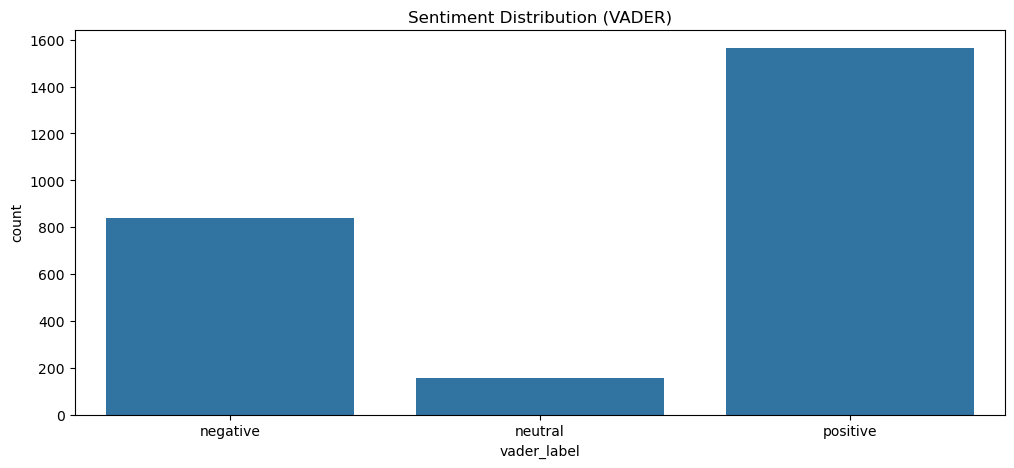

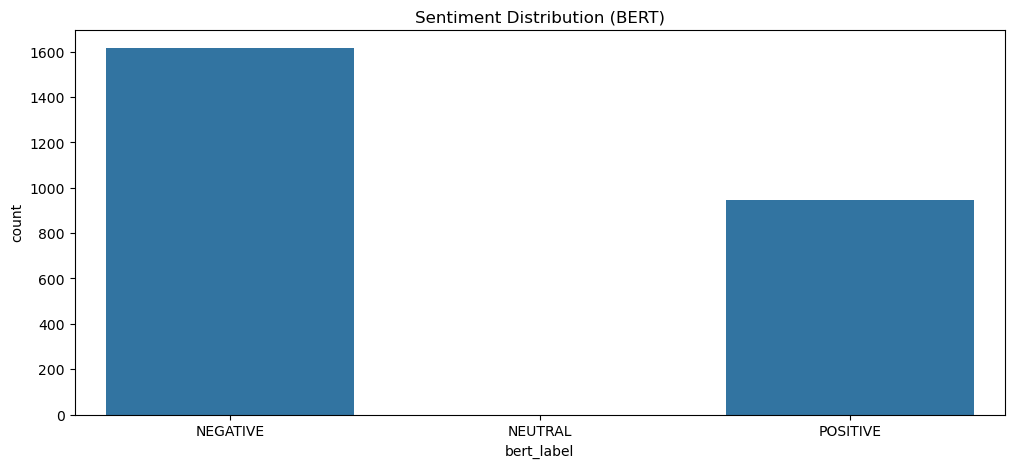

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="vader_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (VADER)")
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="bert_label", order=["NEGATIVE", "NEUTRAL", "POSITIVE"])
plt.title("Sentiment Distribution (BERT)")
plt.show()


In [15]:
# Save processed data with sentiment labels
df.to_csv("../data/processed/sentiment_analysis_results.csv", index=False)
print("Sentiment analysis results saved!")


Sentiment analysis results saved!


In [ ]:
# Show most positive and negative reviews
top_positive = df.nlargest(5, "bert_score")[
    ["lemmatized_text", "bert_label", "bert_score"]
]
top_negative = df.nsmallest(5, "bert_score")[
    ["lemmatized_text", "bert_label", "bert_score"]
]

print("Top 5 Positive Reviews:")
display(top_positive)
print("\nTop 5 Negative Reviews:")
display(top_negative)

Top 5 Positive Reviews:


,lemmatized_text,bert_label,bert_score
1158,"['extraordinary', 'pleasant']",POSITIVE,0.999878
1534,"['enjoy', 'smooth', 'comfortable', 'friendly',...",POSITIVE,0.999871
1495,"['really', 'enjoyable', 'pleasant', 'smile', '...",POSITIVE,0.999863
588,"['awesome', 'airlinevery', 'pleasant', 'delici...",POSITIVE,0.999855
1449,"['punctual', 'seat', 'comfortable', 'food', 's...",POSITIVE,0.999854



Top 5 Negative Reviews:


,lemmatized_text,bert_label,bert_score
2151,"['return', 'south', 'africa', 'prebooke', 'duo...",POSITIVE,0.501560
500,"['process', 'swift', 'really', 'start', 'save'...",NEGATIVE,0.504420
1836,"['oh', 'mon', 'dieuorlyt', 'mad', 'houseno', '...",POSITIVE,0.505483
228,"['drop', 'ocean', 'number', 'review', 'voice',...",NEGATIVE,0.506199
2346,"['first', 'I', 'd', 'fly', 'haul', 'experience...",NEGATIVE,0.506787
